In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

In [143]:
data_I = pd.read_csv('./data_identificada.csv')
data_I.head(1)

,index,Name,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,duration,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,2189,1123-csves/1.csv,4,UDP,NaN,NaN,0.0,0.0,0.0,0.0,...,41346.0,58136.0,1.0,1.0,1.0,34.25,41.5,48.75,not_mine,Does_not_have


In [144]:
data_I = data_I.drop(['index', 'Name'], axis = 1)

# Preprocesado

### Eliminar valores ausentes no imputables

In [145]:
data_I = data_I.drop(['Second_Protocol','Third_Protocol'], axis=1)

### Imputación de valores ausentes

In [146]:
punter = pd.concat([data_I['second_sp'],data_I['second_dp'],data_I['third_sp'],data_I['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy="median")
value = imputer.fit_transform(punter)

In [147]:
temp = data_I.drop(['second_sp','second_dp','third_sp','third_dp'], axis = 1)
punter = pd.DataFrame(value, columns = punter.columns)

In [148]:
data_I = pd.concat([temp,punter], axis = 1)
data_I.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency,second_sp,second_dp,third_sp,third_dp
0,4,UDP,0.0,0.0,0.0,0.0,0.0,0.0,4,442666,...,1.0,34.25,41.5,48.75,not_mine,Does_not_have,41346.0,41346.0,58136.0,58136.0


### Exclusión de variables con varianza próxima a cero

In [149]:
thresholder  = VarianceThreshold(threshold = 0.5)
values = thresholder.fit_transform(data_I[data_numeric])
values

array([[4.000000e+00, 0.000000e+00, 0.000000e+00, ..., 3.425000e+01,
        4.150000e+01, 4.875000e+01],
       [1.500000e+01, 7.404000e+00, 2.987600e+01, ..., 3.975000e+02,
        8.740000e+02, 3.670500e+03],
       [2.000000e+00, 2.002425e+01, 2.003150e+01, ..., 4.302500e+02,
        8.005000e+02, 1.170750e+03],
       ...,
       [2.000000e+00, 2.711955e+02, 2.711970e+02, ..., 2.641750e+03,
        4.939500e+03, 7.237250e+03],
       [2.090000e+02, 0.000000e+00, 0.000000e+00, ..., 3.200000e+01,
        3.700000e+01, 5.420000e+02],
       [1.620000e+02, 0.000000e+00, 6.555000e-01, ..., 3.200000e+01,
        6.400000e+01, 1.277500e+02]])

In [151]:
data_numeric = data_I.select_dtypes(include = ['float64','int64']).columns.to_list()
data_categoric = data_I.select_dtypes(include = ['object']).columns.to_list()

In [152]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), data_numeric), ('onehot', OneHotEncoder(handle_unknown='ignore'), data_categoric)
], remainder='passthrough')

In [158]:
values = preprocessor.fit_transform(data_I)

In [161]:
code = preprocessor.named_transformers_['onehot'].get_feature_names(data_categoric)
labels = np.concatenate([data_numeric,code])
data_IP = pd.DataFrame(values, columns = labels)

### Defino mi variable a predecir y mis predictores

In [168]:
y = data_IP.Type_mine
X = data_IP.drop(['Type_mine','Type_not_mine'],axis = 1)

### Holdout

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3, random_state = 1234)

### KNN

In [220]:
k_vec = np.arange(1,40,2)

In [221]:
vec_train = []
vec_test =[]

for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    vec_train.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test.append(metrics.accuracy_score(y_test, y_pred))
v = pd.DataFrame()
v['K'] = k_vec
v['vec_train'] = vec_train
v['vec_test'] = vec_test
display(v)

,K,vec_train,vec_test
0,1,1.000000,1.000000
1,3,1.000000,0.999296
2,5,1.000000,0.999296
3,7,0.999698,0.999296
4,9,0.999698,0.999296
5,11,0.999698,1.000000
6,13,0.999396,1.000000
7,15,0.999396,1.000000
8,17,0.999396,1.000000
9,19,0.999396,1.000000


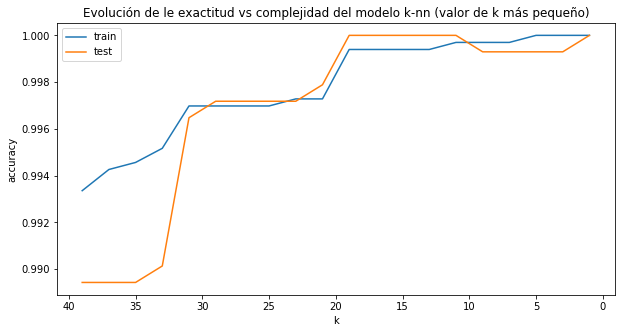

In [222]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train)
plt.plot(k_vec, vec_test)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

In [223]:
k_best = 27

In [224]:
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')

In [225]:
y_pred = knn.predict(X_test)

In [226]:
print("Clases reales :", y_test)
print("Clases reales :", y_pred)

Clases reales : 1906    0.0
1937    0.0
474     0.0
1781    1.0
4392    0.0
4079    1.0
672     0.0
2333    0.0
626     0.0
2208    1.0
369     0.0
1336    0.0
4578    0.0
302     0.0
2221    0.0
760     0.0
1372    0.0
1738    0.0
1391    0.0
1633    1.0
854     0.0
1517    1.0
4595    0.0
1471    1.0
3708    0.0
3372    1.0
4500    1.0
4654    0.0
2059    0.0
3910    0.0
       ... 
1413    1.0
1952    0.0
4394    1.0
3215    1.0
1745    1.0
891     1.0
1221    1.0
3108    1.0
4533    0.0
2661    1.0
3500    0.0
4083    0.0
3117    0.0
2280    0.0
888     0.0
443     0.0
3639    0.0
738     0.0
3231    1.0
1364    1.0
4290    0.0
4553    0.0
2577    0.0
506     1.0
2202    0.0
4404    1.0
2123    0.0
2649    0.0
4195    0.0
3744    0.0
Name: Type_mine, Length: 1420, dtype: float64
Clases reales : [0. 0. 0. ... 0. 0. 0.]


### Métricas y matriz de confusión

([<matplotlib.axis.YTick at 0x1bb5860e6d8>,
 <a list of 2 Text yticklabel objects>)

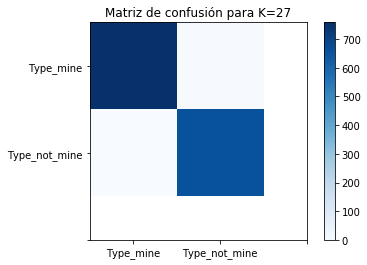

In [227]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.title(f"Matriz de confusión para K={k_best}")
plt.colorbar()
plt.xticks(tick_marks, data_IP[['Type_mine','Type_not_mine']])
plt.yticks(tick_marks, data_IP[['Type_mine','Type_not_mine']])

In [228]:
churm

array([[758,   4],
       [  0, 658]], dtype=int64)

In [ ]:
print()

### Cross_Val_Score

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=11)
exactitud = cross_val_score(knn, X_cod, y_cod, cv = 10, scoring='accuracy')
exactitud

In [ ]:
print("Exactitudes: %0.2f (+/- %0.2f)" % (exactitud.mean(), exactitud.std() * 2), exactitud.mean(), exactitud.std())

In [ ]:
data_no_ident = pd.read_csv('Data_No_Identificada_Tratada.csv', sep=',')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
            ('numeric', numeric_transformer, data_num_c)],remainder='passthrough'
                )

In [ ]:
data_scaler2 = data_no_ident[data_num_c]

In [ ]:
preprocessor.fit_transform(data_scaler2)
datos_transf2 = preprocessor.transform(data_scaler2)
datos_transf2 = pd.DataFrame(datos_transf2, columns=data_scaler2.columns)
datos_transf2 = pd.concat([datos_transf2, data_no_ident[data_obje_c]],axis=1)

In [ ]:
X2 = datos_transf2[data_num_c]
y2 = datos_transf2['Type']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,stratify=y2)

In [ ]:
k_vec = np.arange(1,40,2)
k_vec

In [ ]:
temp = y_test2[0:1184]

In [175]:
vec_train_2 = []
vec_test_2 =[]

for k in  k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_train)
    vec_train_2.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test_2.append(metrics.accuracy_score(temp, y_pred))
v = pd.DataFrame()
v['k'] = k_vec
v['vec_train'] = vec_train_2
v['vec_test'] = vec_test_2
display(v)

NameError: name 'neighbors' is not defined

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train_2)
plt.plot(k_vec, vec_test_2)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
acc_test_vec=[]
for indices_train, indices_test in kf.split(X_cod, y_cod):
    knn.fit(X_cod[indices_train], y_cod[indices_train])
    y_pred = knn.predict(X_cod[indices_test])
    acc_test_vec.append(metrics.accuracy_score(y_cod[indices_test], y_pred))  
acc_test_vec

https://www.analyticslane.com/2018/07/02/gridsearchcv/#:~:text=GridSearchCV%20es%20una%20clase%20disponible,los%20par%C3%A1metros%20de%20un%20modelo.&text=En%20caso%20de%20que%20se,aleatorios%20existe%20el%20m%C3%A9todo%20RandomizedSearchCV.